In [ ]:
 from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, concatenate, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D

In [ ]:
data_dir = '/content/drive/Shareddrives/DeepLearning_2024/FinalProject/Data/kvasir-seg'
results_dir = '/content/drive/Shareddrives/DeepLearning_2024/FinalProject/Results'

# **Data Load**

In [ ]:
# Load and preprocess the data
def load_data(image_dir, mask_dir, img_size=(224, 224)):
    images = []
    masks = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)

        img = load_img(img_path, target_size=img_size)
        mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')

        img = img_to_array(img) / 255.0
        mask = img_to_array(mask) / 255.0

        images.append(img)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    # Standardize images
    mean = np.mean(images)
    std = np.std(images)
    images = (images - mean) / std

    return images, masks

# Paths to the dataset
image_dir = data_dir + '/images'
mask_dir = data_dir + '/masks'

# Load data
images, masks = load_data(image_dir, mask_dir)

In [ ]:
# Split data into training, validation, and test sets
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.3, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.3, random_state=42)

In [ ]:
def visualize_results(model, test_images, test_masks, num_samples=5):
    predictions = model.predict(test_images)
    for i in range(num_samples):
        plt.figure(figsize=(20, 5))

        # Original Image
        plt.subplot(1, 4, 1)
        plt.imshow(test_images[i])
        plt.title('Original Image')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(1, 4, 2)
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(1, 4, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        # Overlay of Original Image with Predicted Mask
        plt.subplot(1, 4, 4)
        plt.imshow(test_images[i])
        plt.imshow(predictions[i].squeeze(), cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')

        plt.show()


In [ ]:
# Plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


# **VGG16 MODEL**

In [ ]:
# VGG16 model for transfer learning
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers for segmentation
inputs = Input(shape=(224, 224, 3))
base_model = vgg16(inputs)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(base_model)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

# Adjust upsampling layers to achieve the original size
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

vgg16_model = Model(inputs, outputs)

# Compile the model
vgg16_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-5)
# Train the model
vgg16_history = vgg16_model.fit(train_images, train_masks, epochs=50, batch_size=8, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = vgg16_model.evaluate(test_images, test_masks)
print(f'Loss: {loss}, Accuracy: {accuracy}')


58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/50
49/49 [==============================] - 26s 211ms/step - loss: 0.4017 - accuracy: 0.8347 - val_loss: 0.2514 - val_accuracy: 0.8980 - lr: 1.0000e-04
Epoch 2/50
49/49 [==============================] - 8s 155ms/step - loss: 0.2545 - accuracy: 0.8928 - val_loss: 0.2175 - val_accuracy: 0.9118 - lr: 1.0000e-04
Epoch 3/50
49/49 [==============================] - 8s 157ms/step - loss: 0.1868 - accuracy: 0.9205 - val_loss: 0.1420 - val_accuracy: 0.9393 - lr: 1.0000e-04
Epoch 4/50
49/49 [==============================] - 8s 156ms/step - loss: 0.1396 - accuracy: 0.9392 - val_loss: 0.1490 - val_accuracy: 0.9345 - lr: 1.0000e-04
Epoch 5/50
49/49 [==============================] - 8s 160ms/step - loss: 0.1308 - accuracy: 0.9445 - val_loss: 0.1419 - val_accuracy: 0.9394 - lr: 1.0000e-04
Epoch 6/50
49/49 [==============================] - 8s 160ms/step - loss: 0.1068 - accuracy: 0.9531 - val_loss: 0.1637 - val_accuracy: 0.93

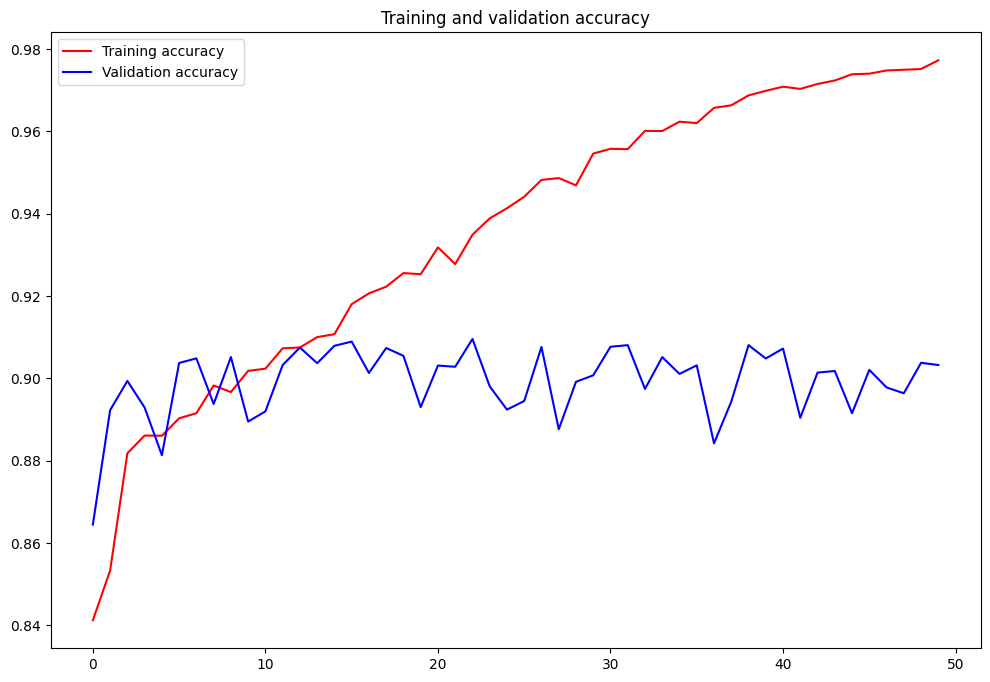

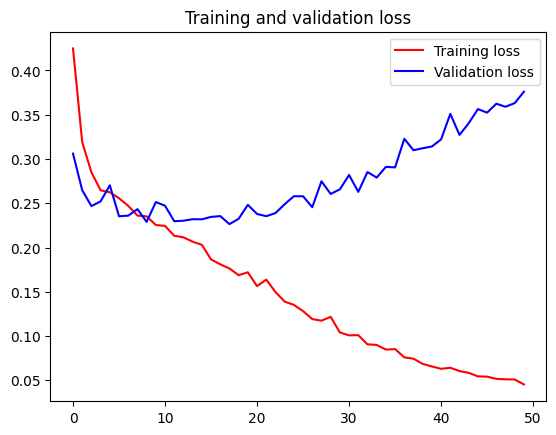

In [ ]:
 plot_history(vgg16_history)

10/10 [==============================] - 2s 147ms/step


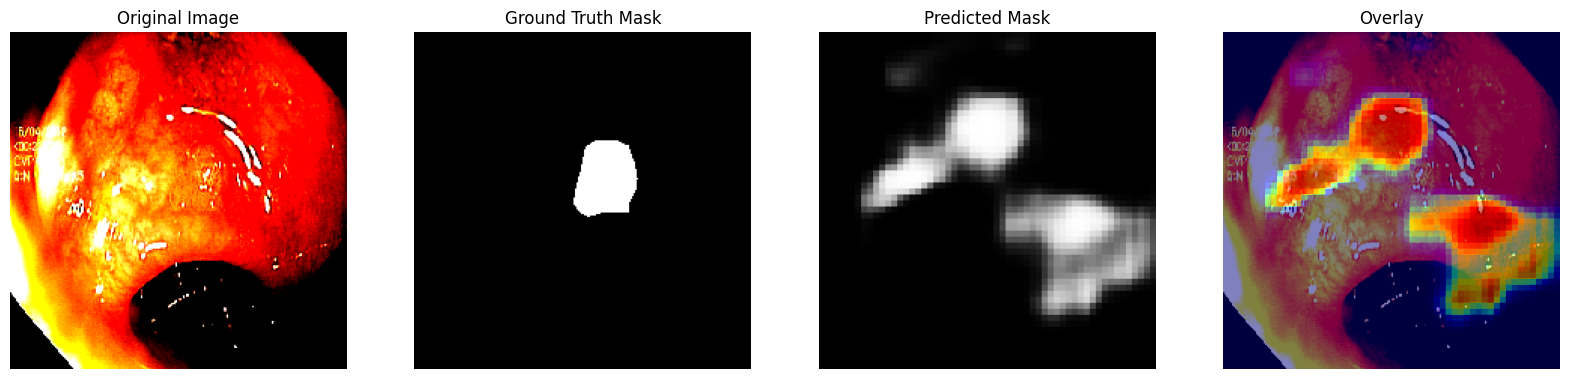

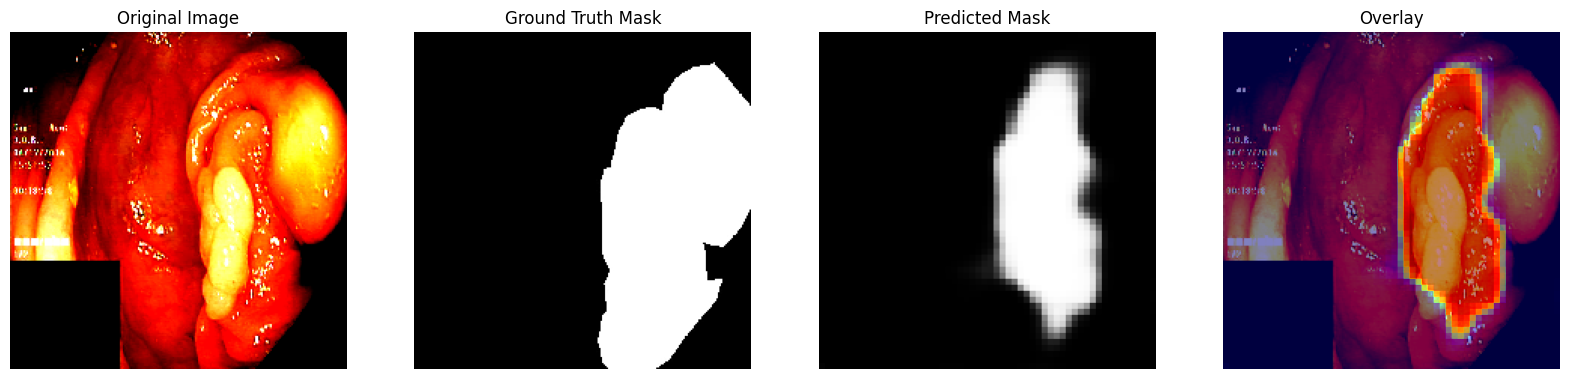

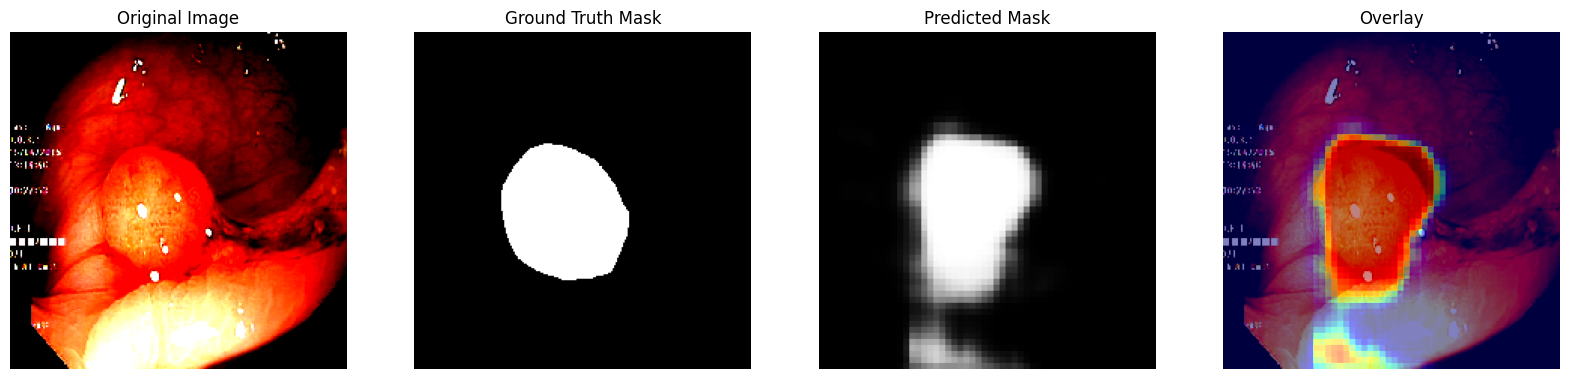

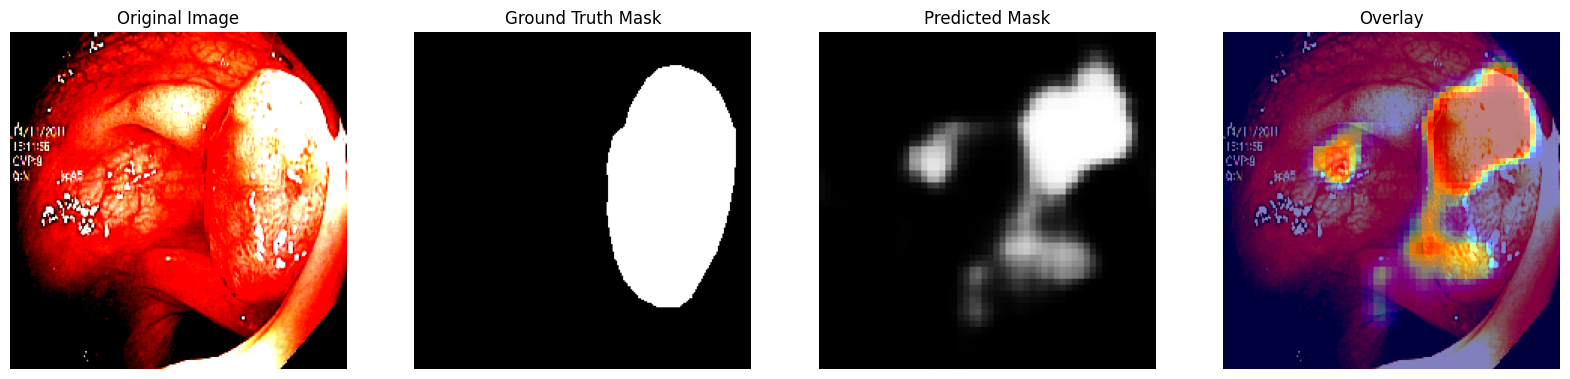

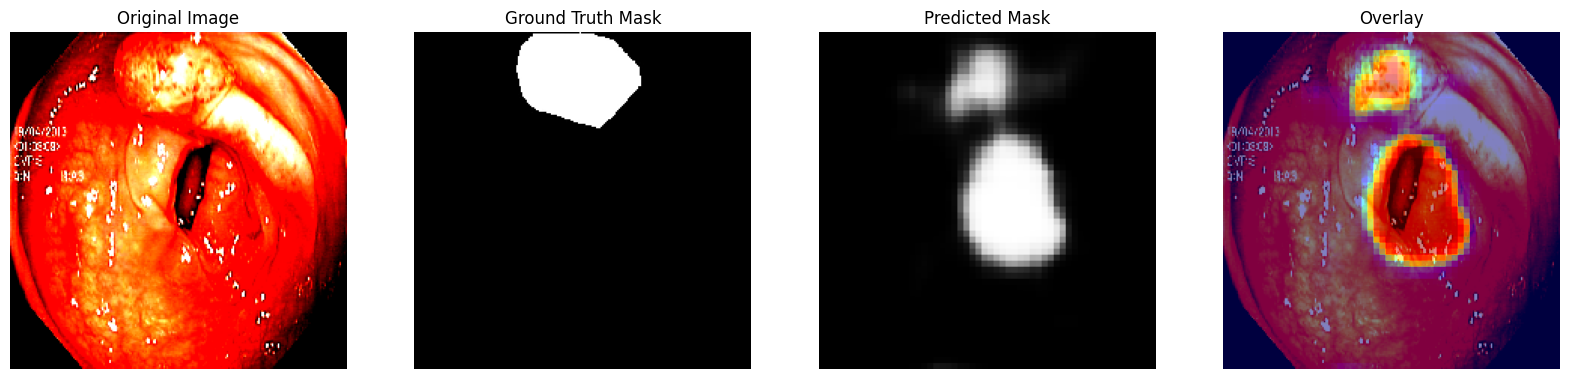

In [ ]:
visualize_results(vgg16_model, test_images, test_masks)



---



---



# **Inception V3 model**

In [ ]:
# InceptionV3 model for transfer learning
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers for segmentation
inputs = Input(shape=(224, 224, 3))
base_model = inceptionv3(inputs, training=False)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(base_model)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

# Define the model
inceptionv3_model = Model(inputs, outputs)
# Compile the model
inceptionv3_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


#The size change occurs because of the downsampling and upsampling operations in the neural network architecture.

# Resize target masks to match model output
train_masks_reshaped = train_masks.reshape(-1, 224, 224, 1)
val_masks_reshaped = val_masks.reshape(-1, 224, 224, 1)
test_masks_reshaped = test_masks.reshape(-1, 224, 224, 1)

# Resize target masks to match model output
train_masks_resized = tf.image.resize(train_masks_reshaped, (160, 160))
val_masks_resized = tf.image.resize(val_masks_reshaped, (160, 160))
test_masks_resized = tf.image.resize(test_masks_reshaped, (160, 160))

# Train the model
# inceptionv3_history = inceptionv3_model.fit(train_images, train_masks, epochs=50, batch_size=8, validation_split=0.2)

inceptionv3_history = inceptionv3_model.fit(train_images, train_masks_resized, epochs=50, batch_size=8, validation_data=(val_images, val_masks_resized))

# Evaluate the model
loss, accuracy = inceptionv3_model.evaluate(test_images, test_masks_resized)
print(f'Loss: {loss}, Accuracy: {accuracy}')

87910968/87910968 [==============================] - 6s 0us/step
Epoch 1/50
62/62 [==============================] - 14s 108ms/step - loss: 0.4745 - accuracy: 0.8253 - val_loss: 0.3751 - val_accuracy: 0.8361
Epoch 2/50
62/62 [==============================] - 3s 51ms/step - loss: 0.3473 - accuracy: 0.8493 - val_loss: 0.3475 - val_accuracy: 0.8431
Epoch 3/50
62/62 [==============================] - 3s 51ms/step - loss: 0.3261 - accuracy: 0.8545 - val_loss: 0.3629 - val_accuracy: 0.8472
Epoch 4/50
62/62 [==============================] - 3s 42ms/step - loss: 0.3098 - accuracy: 0.8586 - val_loss: 0.3258 - val_accuracy: 0.8495
Epoch 5/50
62/62 [==============================] - 3s 54ms/step - loss: 0.2968 - accuracy: 0.8664 - val_loss: 0.3378 - val_accuracy: 0.8527
Epoch 6/50
62/62 [==============================] - 3s 51ms/step - loss: 0.2841 - accuracy: 0.8700 - val_loss: 0.3173 - val_accuracy: 0.8540
Epoch 7/50
62/62 [==============================] - 3s 51ms/step - loss: 0.2736 - accur

In [ ]:
loss, accuracy = inceptionv3_model.evaluate(test_images, test_masks_resized)
print(f'Loss: {loss}, Accuracy: {accuracy}')

10/10 [==============================] - 1s 76ms/step - loss: 0.9623 - accuracy: 0.8464
Loss: 0.9622805714607239, Accuracy: 0.8463574051856995


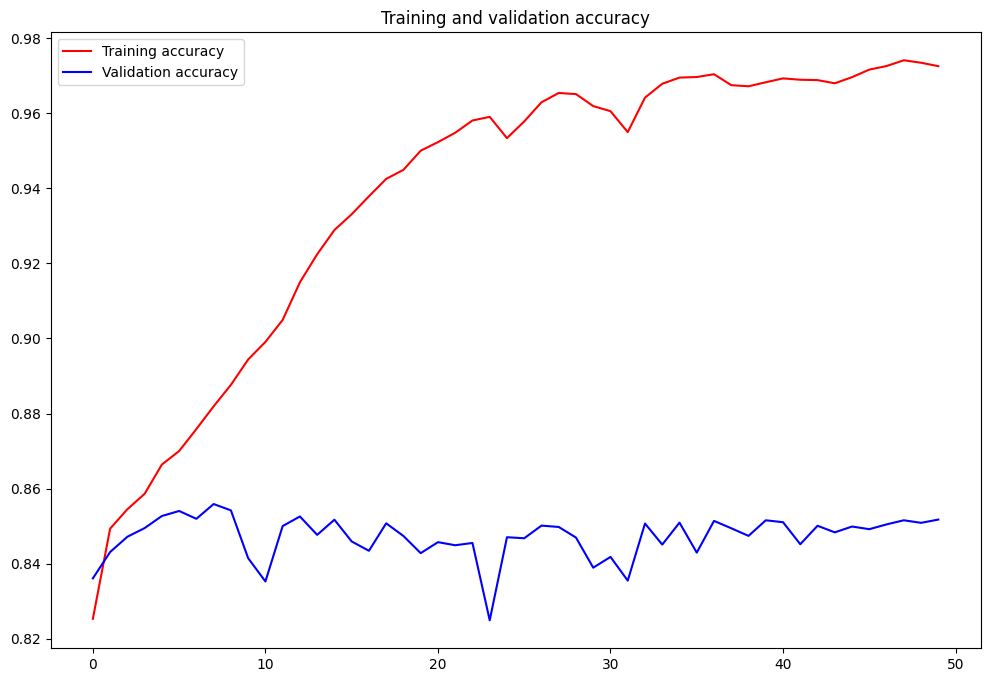

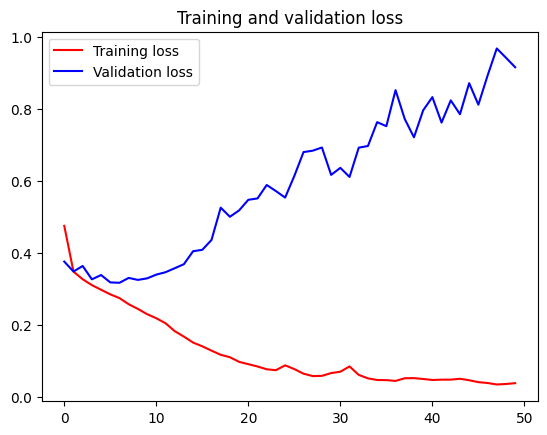

In [ ]:
plot_history(inceptionv3_history)

10/10 [==============================] - 2s 79ms/step


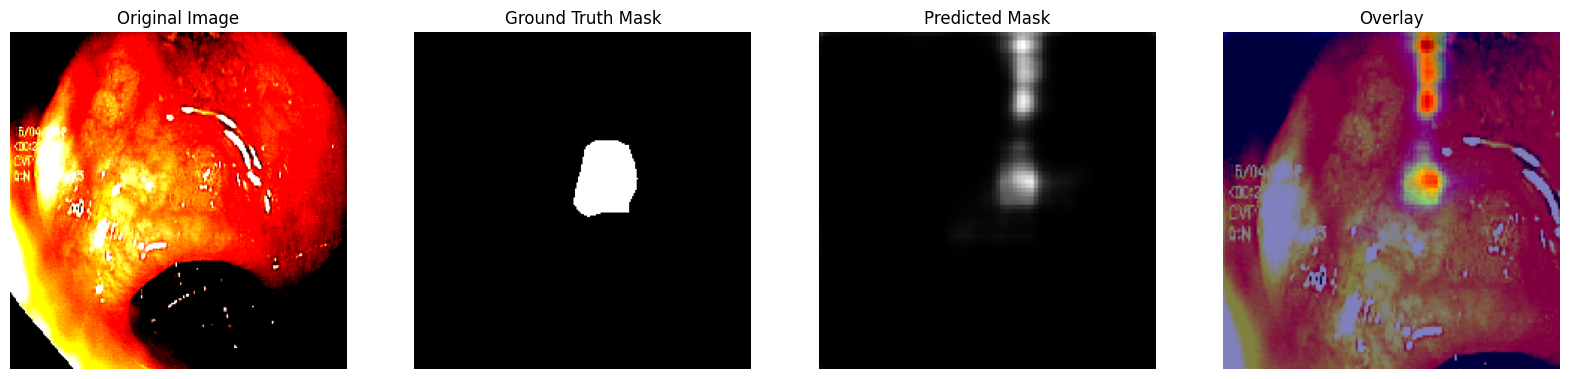

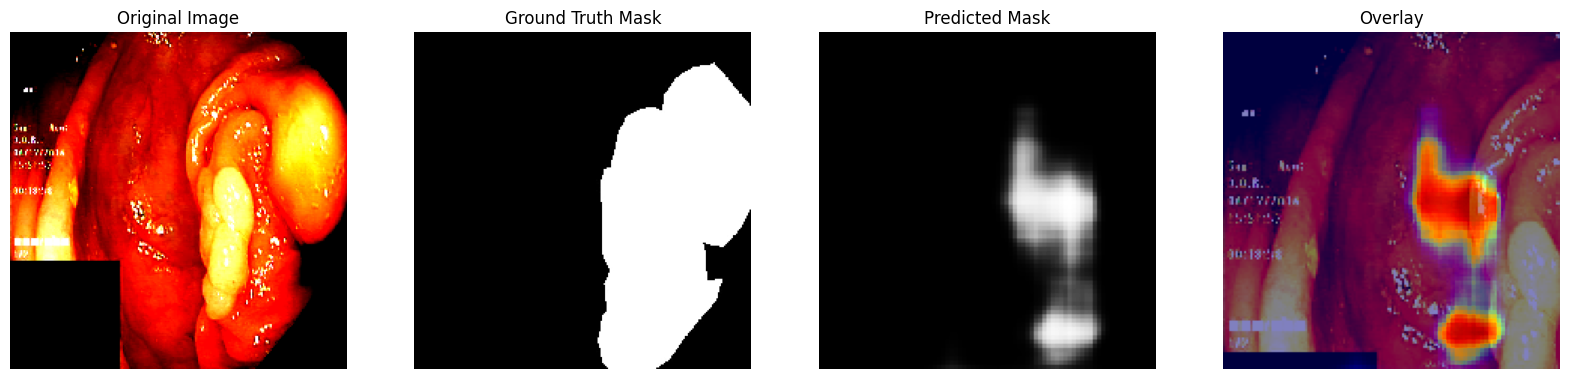

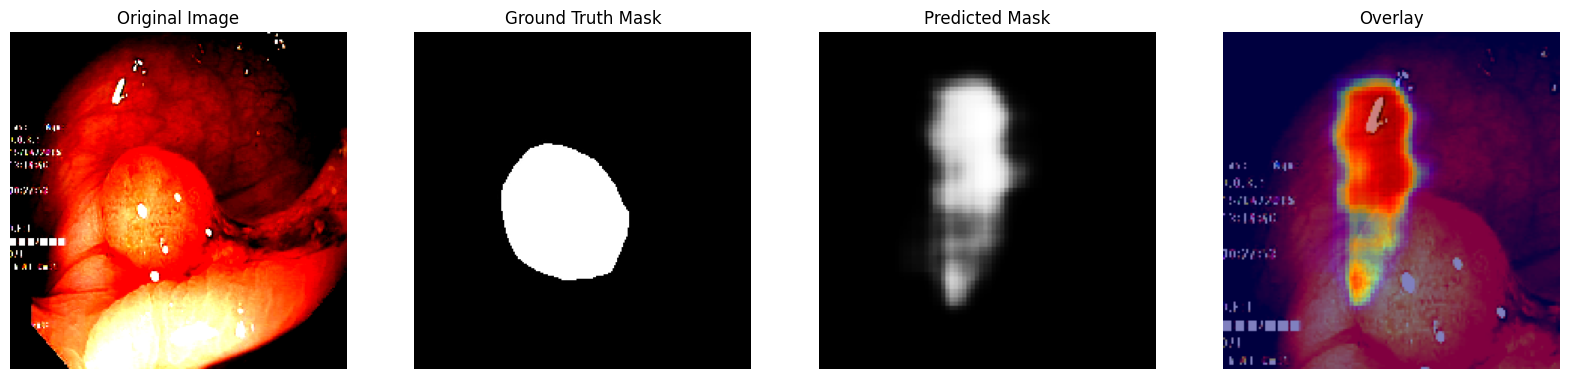

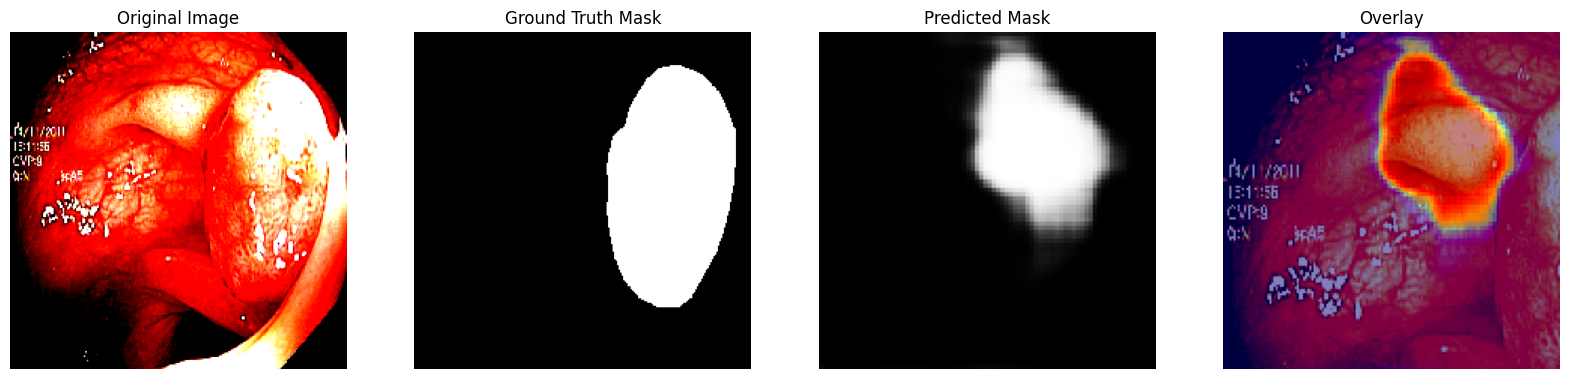

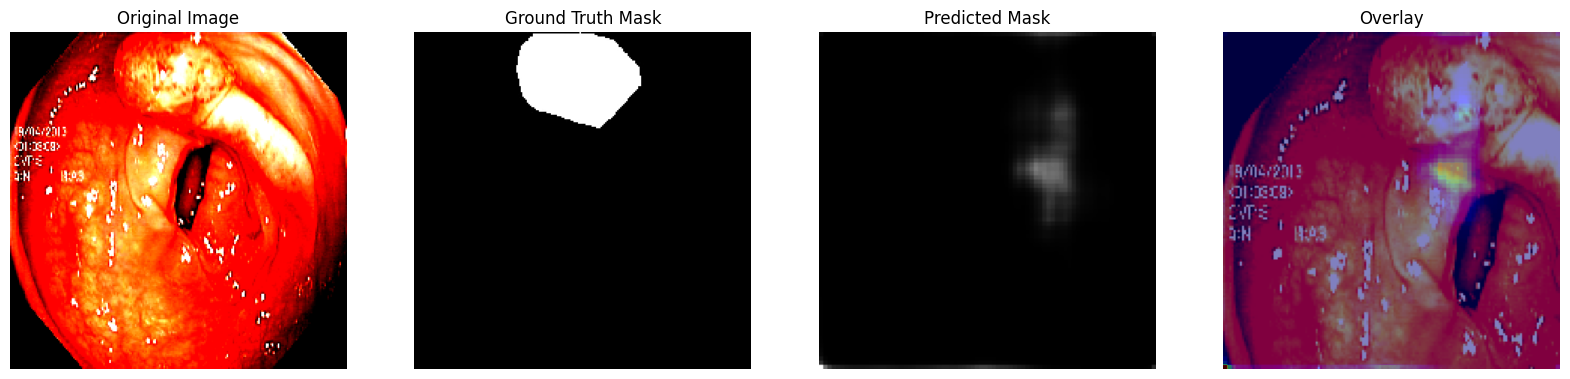

In [ ]:
visualize_results(inceptionv3_model, test_images, test_masks)

# **ResNet50**

In [ ]:
# ResNet50 model for transfer learning
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers for segmentation
inputs = Input(shape=(224, 224, 3))
base_model = resnet50(inputs, training=False)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(base_model)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

# Define the model
resnet50_model = Model(inputs, outputs)

# Compile the model
resnet50_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Resize target masks to match model output
# Ensure masks have the correct shape
train_masks_reshaped = train_masks.reshape(-1, 224, 224, 1)
val_masks_reshaped = val_masks.reshape(-1, 224, 224, 1)
test_masks_reshaped = test_masks.reshape(-1, 224, 224, 1)

# Resize target masks to match model output
train_masks_resized = tf.image.resize(train_masks_reshaped, (224, 224))
val_masks_resized = tf.image.resize(val_masks_reshaped, (224, 224))
test_masks_resized = tf.image.resize(test_masks_reshaped, (224, 224))

# Train the model
resnet50_history = resnet50_model.fit(train_images, train_masks_resized, epochs=50, batch_size=8, validation_data=(val_images, val_masks_resized))

# Evaluate the model
loss, accuracy = resnet50_model.evaluate(test_images, test_masks_resized)
print(f'Loss: {loss}, Accuracy: {accuracy}')


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/50
62/62 [==============================] - 57s 201ms/step - loss: 0.3953 - accuracy: 0.8445 - val_loss: 0.3632 - val_accuracy: 0.8396
Epoch 2/50
62/62 [==============================] - 8s 136ms/step - loss: 0.3634 - accuracy: 0.8460 - val_loss: 0.3634 - val_accuracy: 0.8396
Epoch 3/50
62/62 [==============================] - 8s 132ms/step - loss: 0.3679 - accuracy: 0.8460 - val_loss: 0.3623 - val_accuracy: 0.8396
Epoch 4/50
62/62 [==============================] - 8s 133ms/step - loss: 0.3605 - accuracy: 0.8460 - val_loss: 0.3600 - val_accuracy: 0.8396
Epoch 5/50
62/62 [==============================] - 9s 138ms/step - loss: 0.3633 - accuracy: 0.8460 - val_loss: 0.3627 - val_accuracy: 0.8396
Epoch 6/50
62/62 [==============================] - 9s 141ms/step - loss: 0.3645 - accuracy: 0.8460 - val_loss: 0.3650 - val_accuracy: 0.8396
Epoch 7/50
62/62 [==============================] - 9s 141ms/step - loss: 0.3620 -

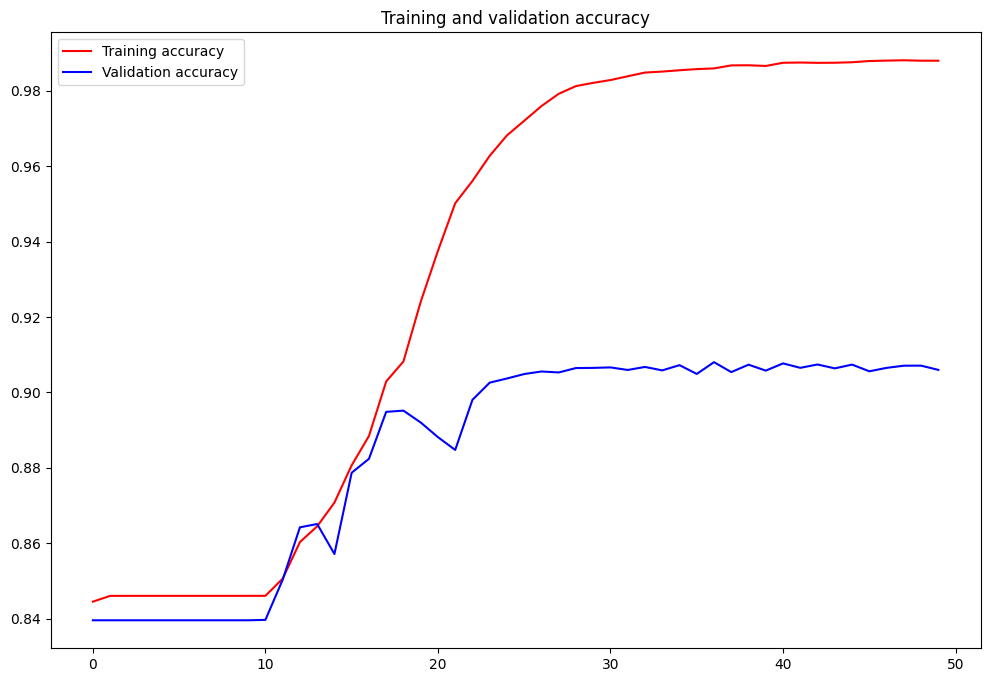

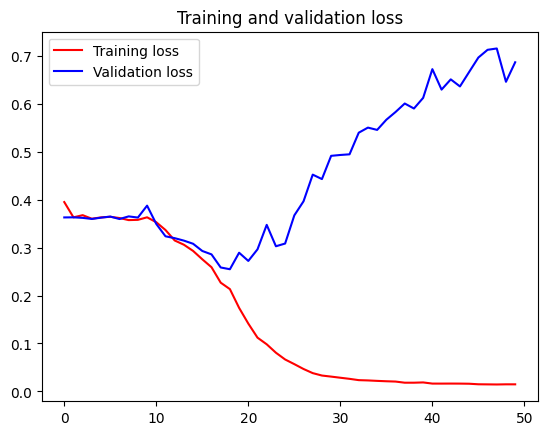

In [ ]:
plot_history(resnet50_history)

10/10 [==============================] - 1s 109ms/step


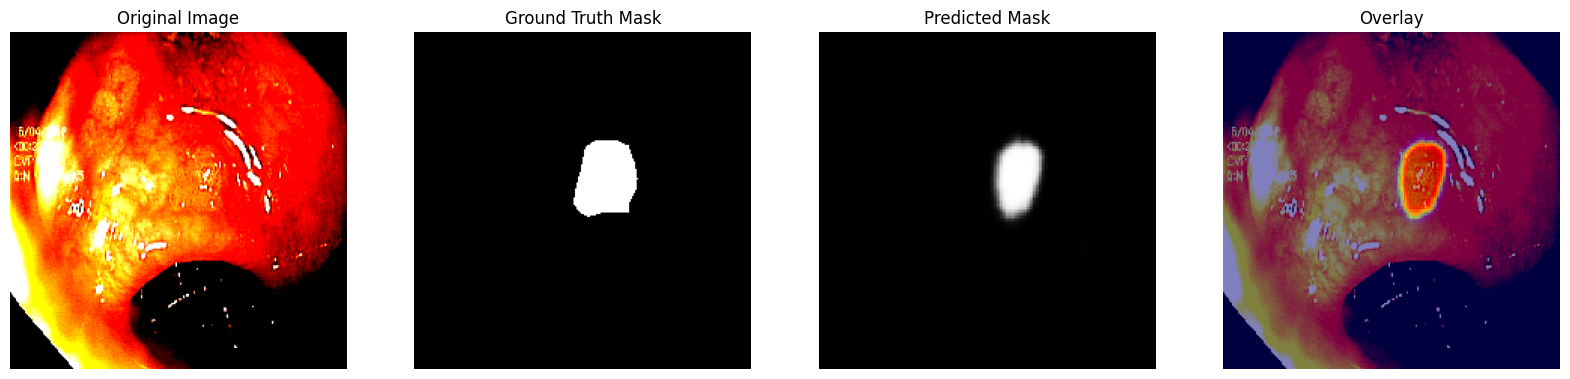

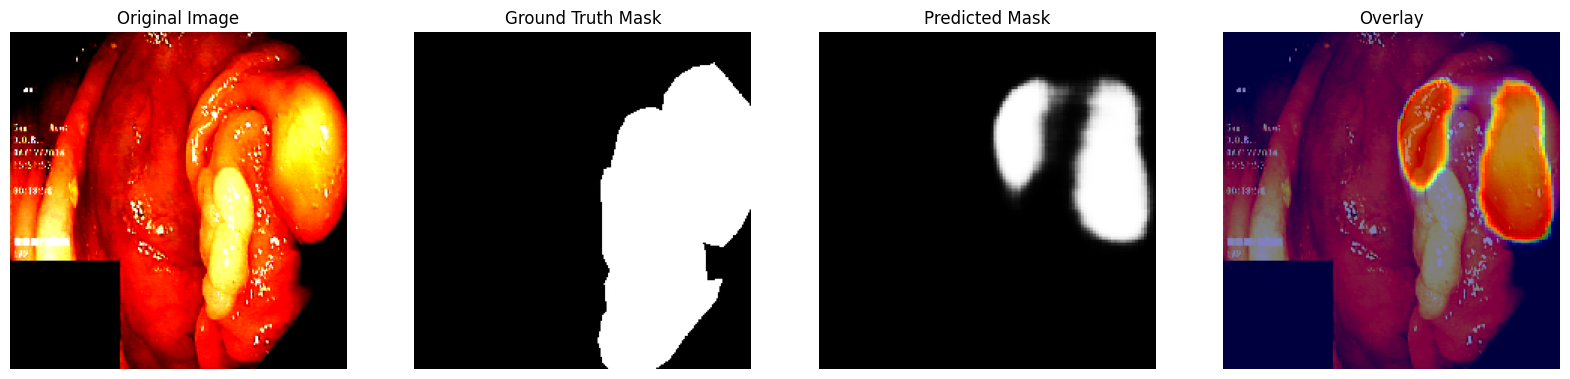

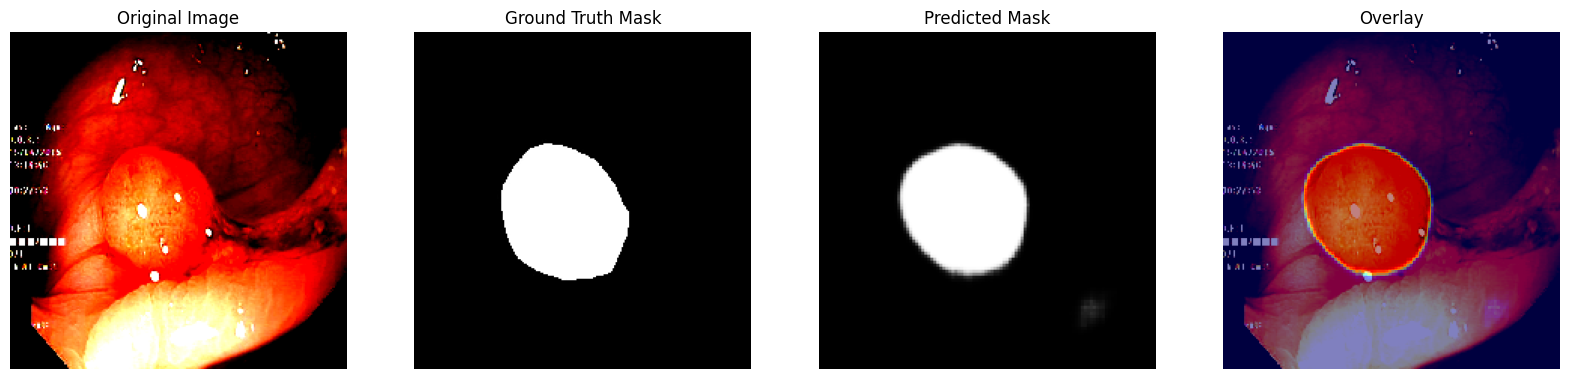

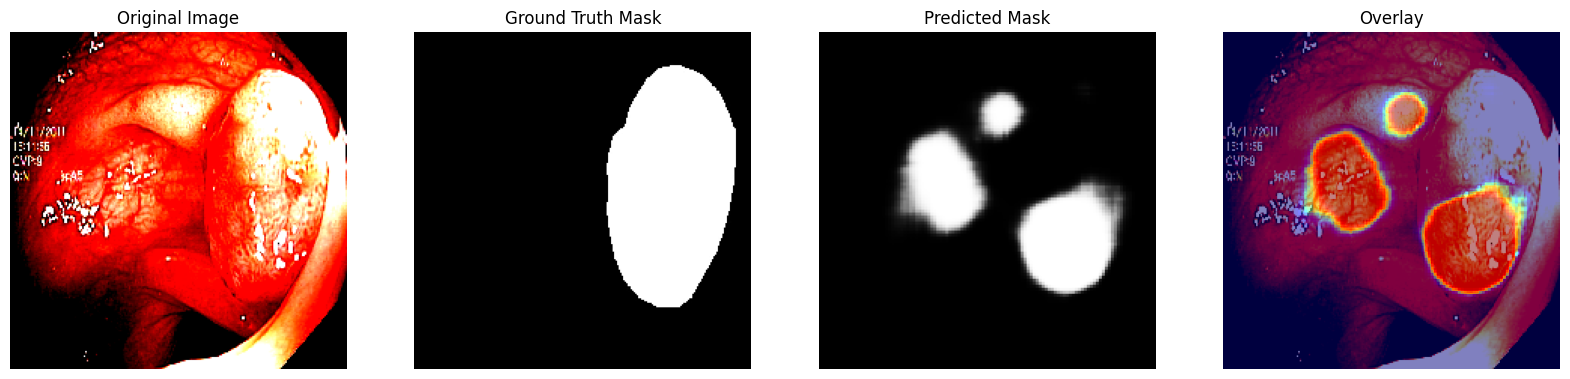

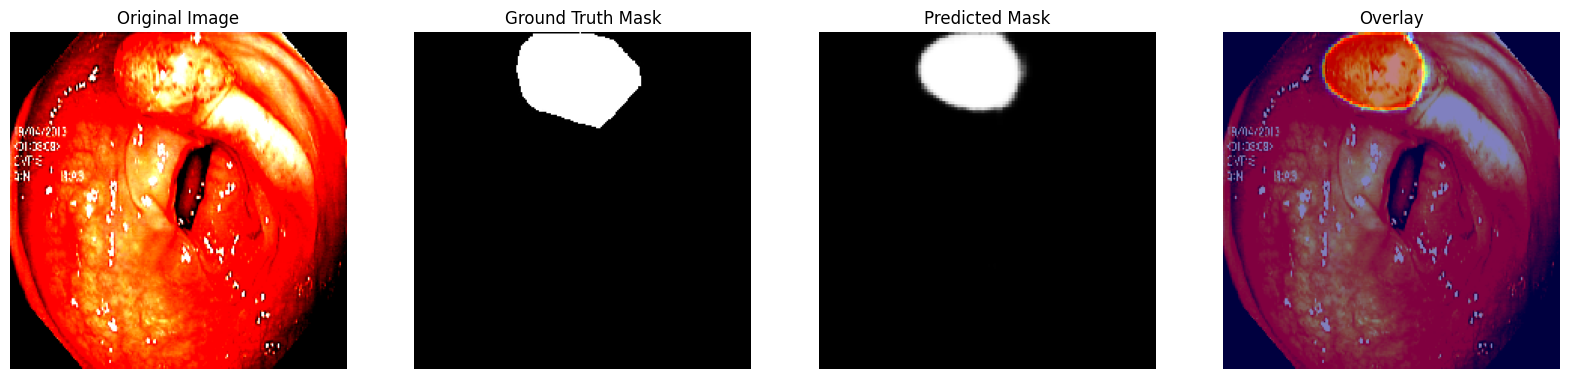

In [ ]:
visualize_results(resnet50_model, test_images, test_masks)